In [3]:
# Imports
import pandas as pd
import numpy as np
import os
import joblib
import logging
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load dataset (adjust path & delimiter accordingly)
dataset_path = '3_merged_data3.txt'
data = pd.read_csv(dataset_path, sep='\t')  # or sep=',' if CSV

# Load p-values file
pval_path = '3_transposed_headers_with_scores.txt'
pvals = pd.read_csv(pval_path, sep='\t')

In [6]:
# Get list of features from dataset columns
dataset_features = set(data.columns)

# Get list of features from p-value file
pval_features = set(pvals['isoform'])

# Find missing and extra features
missing_in_pval = dataset_features - pval_features
extra_in_pval = pval_features - dataset_features

# Print results
print(f"Features in dataset not in p-value file: {len(missing_in_pval)}")
if missing_in_pval:
    print("Missing features:\n", missing_in_pval)

print(f"Extra features in p-value file not in dataset: {len(extra_in_pval)}")
if extra_in_pval:
    print("Extra features:\n", extra_in_pval)


Features in dataset not in p-value file: 2
Missing features:
 {'ID', 'avg7_calingiri'}
Extra features in p-value file not in dataset: 0


In [7]:
# Extract features and target (assuming 'avg7_calingiri' is target)
target_col = 'avg7_calingiri'
feature_cols = [col for col in data.columns if col != target_col and col != 'ID']

X = data[feature_cols]
y = data[target_col]

# Map p-values by feature
pval_map = pvals.set_index('isoform')['p-value_lowest'].to_dict()
print(X.shape)

(149, 33048)


In [8]:
weights = {}
for feat in feature_cols:
    p = pval_map.get(feat, None)
    if p is None:
        weights[feat] = 1.0
    else:
        weights[feat] = 1.0 / (p + 1e-8)


In [9]:
print(type(weights))

<class 'dict'>


In [10]:
# Step 1: Clamp weights to avoid extremes [0.01, 100]
weights_clamped = {
    feat: np.clip(weight, 1e-2, 100)
    for feat, weight in weights.items()
}

# Step 2: Normalize weights to range [0.01, 1]
clamped_vals = np.array(list(weights_clamped.values()))
min_val, max_val = clamped_vals.min(), clamped_vals.max()

weights_norm = {
    feat: ((val - min_val) / (max_val - min_val)) * (1 - 0.01) + 0.01
    for feat, val in weights_clamped.items()
}


In [11]:
print(type(weights_norm))

<class 'dict'>


In [12]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
weights_series = pd.Series(weights_norm)

# Now multiply features by these  weights
X_train_weighted = X_train * weights_series
X_test_weighted = X_test * weights_series
print(X_train_weighted.shape)
print("New weighted features stats:",
      X_train_weighted.min().min(),
      X_train_weighted.max().max(),
      X_train_weighted.std().mean())


(119, 33048)
New weighted features stats: 0.0 4.0 0.20485378840529936


In [14]:
print("Feature variance stats:", np.var(X_train_weighted, axis=0).min(), np.var(X_train_weighted, axis=0).max())
print("Target variance:", np.var(y_train))


Feature variance stats: 0.0 1.2602217357531245
Target variance: 1.6101913424193206


In [15]:
from sklearn.feature_selection import VarianceThreshold

# Step 1: Init the selector
selector = VarianceThreshold(threshold=1e-5)

# Step 2: Fit only on TRAIN
X_train_filtered = selector.fit_transform(X_train_weighted)

# Step 3: Use .transform() on VAL and TEST
X_test_filtered = selector.transform(X_test_weighted)


In [16]:
models = {
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
}

In [17]:
print(X_train_filtered.shape)

(119, 29946)


In [18]:
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger()

model_save_dir = 'saved_models'
os.makedirs(model_save_dir, exist_ok=True)

results = {}

logger.info(f"Starting training for {len(models)} models...")

for name, model in tqdm(models.items(), desc="Models", unit="model"):
    logger.info(f"Training {name}...")
    try:
        model.fit(X_train_filtered, y_train)
        y_pred = model.predict(X_test_filtered)
        mse = mean_squared_error(y_test, y_pred)
        results[name] = mse

        model_path = os.path.join(model_save_dir, f"{name}.model")
        if name == 'CatBoost':
            model.save_model(model_path, format='cbm')
        else:
            model.save_model(model_path)

        logger.info(f"{name} saved to {model_path} with Test MSE: {mse:.4f}")

    except Exception as e:
        logger.error(f"Error training {name}: {e}")





Models:  33%|███▎      | 1/3 [00:03<00:06,  3.36s/model]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49663
[LightGBM] [Info] Number of data points in the train set: 119, number of used features: 24730
[LightGBM] [Info] Start training from score 4.115210
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

ERROR:root:Error training LightGBM: 'LGBMRegressor' object has no attribute 'save_model'
Models:  67%|██████▋   | 2/3 [00:08<00:04,  4.25s/model]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Models: 100%|██████████| 3/3 [02:18<00:00, 46.32s/model]


In [19]:
# =============================================================================
# FEATURE IMPACT ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("STARTING COMPREHENSIVE FEATURE IMPACT ANALYSIS")
print("="*80)

# Get feature names after variance filtering
feature_names_filtered = []
for i, feat in enumerate(feature_cols):
    if selector.get_support()[i]:
        feature_names_filtered.append(feat)

print(f"Analyzing {len(feature_names_filtered)} features after variance filtering...")



STARTING COMPREHENSIVE FEATURE IMPACT ANALYSIS
Analyzing 29946 features after variance filtering...


In [20]:
# =============================================================================
# 1. BUILT-IN FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n" + "="*60)
print("1. BUILT-IN FEATURE IMPORTANCE ANALYSIS")
print("="*60)

importance_results = {}

for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        # Get feature importance
        importance = model.feature_importances_

        # Convert to percentage
        importance_pct = (importance / importance.sum()) * 100

        # Create DataFrame for easier handling
        feature_imp_df = pd.DataFrame({
            'feature': feature_names_filtered,
            'importance': importance,
            'importance_pct': importance_pct,
            'p_value_weight': [weights_norm.get(feat, 1.0) for feat in feature_names_filtered]
        }).sort_values('importance_pct', ascending=False)

        importance_results[f'{name}_builtin'] = feature_imp_df

        print(f"\n{name} - Top 15 Most Important Features:")
        print(feature_imp_df.head(15)[['feature', 'importance_pct', 'p_value_weight']].to_string(index=False))


1. BUILT-IN FEATURE IMPORTANCE ANALYSIS

XGBoost - Top 15 Most Important Features:
       feature  importance_pct  p_value_weight
SNOO_556270_22        6.267510        1.000000
SNOO_062850A_1        5.441267        0.538468
SNOO_037720A_2        5.115915        0.666694
SNOO_422580A_1        5.024435        0.418690
SNOO_111140A_1        4.722610        1.000000
SNOO_145830A_1        3.868776        1.000000
SNOO_028640A_1        3.604434        1.000000
SNOO_444600A_2        2.906412        0.085544
SNOO_305050A_2        2.701714        0.347299
SNOO_077410A_2        2.425402        1.000000
SNOO_440140A_1        2.398447        0.489785
SNOO_099300A_2        2.324775        0.720843
 SNOO_547190_1        2.280819        1.000000
SNOO_424640A_1        2.055322        1.000000
SNOO_161060A_1        1.908231        1.000000

LightGBM - Top 15 Most Important Features:
       feature  importance_pct  p_value_weight
 SNOO_514440_2        3.867403        1.000000
SNOO_400190A_1        2.76

In [21]:
# =============================================================================
# 2. PERMUTATION IMPORTANCE ANALYSIS (FIXED)
# =============================================================================
print("\n" + "="*60)
print("2. PERMUTATION IMPORTANCE ANALYSIS")
print("="*60)

for name, model in models.items():
    print(f"\nCalculating permutation importance for {name}...")

    # Calculate permutation importance
    perm_importance = permutation_importance(
        model, X_test_filtered, y_test,
        n_repeats=10, random_state=42, scoring='neg_mean_squared_error'
    )

    # Get raw importance scores
    perm_imp_mean = perm_importance.importances_mean
    perm_imp_std = perm_importance.importances_std

    # Diagnostic information
    print(f"\nDiagnostic Information for {name}:")
    print(f"Raw importance range: {perm_imp_mean.min():.6f} to {perm_imp_mean.max():.6f}")
    print(f"Sum of raw importances: {perm_imp_mean.sum():.6f}")
    print(f"Number of negative importances: {(perm_imp_mean < 0).sum()}")
    print(f"Number of positive importances: {(perm_imp_mean > 0).sum()}")

    # Handle percentage calculation properly
    positive_importances = perm_imp_mean[perm_imp_mean > 0]

    if len(positive_importances) > 0 and positive_importances.sum() > 0:
        # Calculate percentages only for positive importances
        perm_imp_pct = np.zeros_like(perm_imp_mean)
        perm_imp_pct[perm_imp_mean > 0] = (positive_importances / positive_importances.sum()) * 100
        perm_imp_pct[perm_imp_mean <= 0] = 0  # Set negative/zero importances to 0%
    else:
        print(f"Warning: No positive importances found for {name}!")
        perm_imp_pct = np.zeros_like(perm_imp_mean)

    # Calculate statistical significance (basic approach)
    # A feature is "significant" if its importance is > 2 standard deviations from 0
    significance_threshold = 2
    is_significant = np.abs(perm_imp_mean) > (significance_threshold * perm_imp_std)

    # Create comprehensive DataFrame
    perm_imp_df = pd.DataFrame({
        'feature': feature_names_filtered,
        'perm_importance_raw': perm_imp_mean,
        'perm_importance_std': perm_imp_std,
        'perm_importance_pct': perm_imp_pct,
        'is_significant': is_significant,
        'abs_importance': np.abs(perm_imp_mean),
        'p_value_weight': [weights_norm.get(feat, 1.0) for feat in feature_names_filtered],
        'importance_rank': np.argsort(-np.abs(perm_imp_mean)) + 1
    })

    # Sort by absolute importance (most impactful features first)
    perm_imp_df = perm_imp_df.sort_values('abs_importance', ascending=False)

    # Store results
    importance_results[f'{name}_permutation'] = perm_imp_df

    # Display results
    print(f"\n{name} - Top 15 Features by Permutation Importance:")
    print("="*80)

    display_df = perm_imp_df.head(15)[['feature', 'perm_importance_raw', 'perm_importance_pct',
                                      'is_significant', 'p_value_weight']].copy()

    # Format for better display
    display_df['perm_importance_raw'] = display_df['perm_importance_raw'].round(6)
    display_df['perm_importance_pct'] = display_df['perm_importance_pct'].round(2)
    display_df['p_value_weight'] = display_df['p_value_weight'].round(6)

    print(display_df.to_string(index=False))

    # Summary statistics
    print(f"\nSummary for {name}:")
    print(f"- Significant features (|importance| > 2*std): {is_significant.sum()}")
    print(f"- Features with positive importance: {(perm_imp_mean > 0).sum()}")
    print(f"- Features with negative importance: {(perm_imp_mean < 0).sum()}")
    print(f"- Total percentage (should be 100%): {perm_imp_pct.sum():.2f}%")

    # Identify potentially problematic features
    high_importance_low_weight = perm_imp_df[
        (perm_imp_df['abs_importance'] > perm_imp_df['abs_importance'].quantile(0.8)) &
        (perm_imp_df['p_value_weight'] < 0.5)
    ]

    if len(high_importance_low_weight) > 0:
        print(f"\n⚠️  Warning: Features with high importance but low p-value weight:")
        for _, row in high_importance_low_weight.iterrows():
            print(f"   - {row['feature']}: importance={row['perm_importance_raw']:.6f}, "
                  f"weight={row['p_value_weight']:.6f}")
        print("   These may indicate overfitting or data leakage issues.")

    print("\n" + "-"*80)


2. PERMUTATION IMPORTANCE ANALYSIS

Calculating permutation importance for XGBoost...
XGBoost - Top 15 Features by Permutation Importance:
       feature  perm_importance_pct  p_value_weight
SNOO_424720A_3           204.882104        0.176484
SNOO_111140A_1           168.062042        1.000000
SNOO_028640A_1           130.101506        1.000000
SNOO_037720A_2            54.452573        0.666694
 SNOO_512200_1            41.923435        1.000000
 SNOO_514440_2            41.910281        1.000000
SNOO_422580A_1            34.956184        0.418690
 SNOO_547190_1            34.842834        1.000000
 SNOO_529730_1            28.031353        0.685993
SNOO_305830A_1            27.528266        0.603503
 SNOO_514350_3            24.320865        1.000000
 SNOO_649840_1            23.847754        0.583183
SNOO_099300A_2            22.959871        0.720843
SNOO_122480A_2            22.701101        1.000000
 SNOO_521910_1            21.920826        1.000000

Calculating permutation imp

KeyboardInterrupt: 

In [22]:
# =============================================================================
# 3. LINEAR REGRESSION COEFFICIENT ANALYSIS
# =============================================================================
print("\n" + "="*60)
print("3. LINEAR REGRESSION COEFFICIENT ANALYSIS")
print("="*60)

# Standardize features for fair coefficient comparison
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Get absolute coefficients as importance measure
coef_abs = np.abs(lr_model.coef_)
coef_pct = (coef_abs / coef_abs.sum()) * 100

coef_df = pd.DataFrame({
    'feature': feature_names_filtered,
    'coefficient': lr_model.coef_,
    'abs_coefficient': coef_abs,
    'coef_importance_pct': coef_pct,
    'p_value_weight': [weights_norm.get(feat, 1.0) for feat in feature_names_filtered]
}).sort_values('coef_importance_pct', ascending=False)

importance_results['linear_regression'] = coef_df

print("Linear Regression - Top 15 Features by Coefficient Magnitude:")
print(coef_df.head(15)[['feature', 'coefficient', 'coef_importance_pct', 'p_value_weight']].to_string(index=False))


3. LINEAR REGRESSION COEFFICIENT ANALYSIS
Linear Regression - Top 15 Features by Coefficient Magnitude:
       feature  coefficient  coef_importance_pct  p_value_weight
SNOO_440140A_1     0.084769             0.409033        0.489785
SNOO_115540A_1    -0.079575             0.383972        0.073625
 SNOO_557080_1     0.074442             0.359203        0.120156
SNOO_400190A_1     0.069023             0.333056        1.000000
 SNOO_553780_2    -0.063140             0.304668        0.261010
SNOO_152040A_1    -0.060384             0.291367        0.290188
SNOO_434500A_1     0.060109             0.290040        1.000000
 SNOO_530230_1     0.058168             0.280678        1.000000
SNOO_438580A_1    -0.057938             0.279566        0.396131
 SNOO_616190_1    -0.056693             0.273557        0.185571
SNOO_050270A_1    -0.056311             0.271714        1.000000
 SNOO_581870_1    -0.056100             0.270697        0.170525
 SNOO_631920_1     0.055613             0.268349  

In [23]:
# =============================================================================
# 4. FEATURE-TARGET CORRELATION ANALYSIS
# =============================================================================
print("\n" + "="*60)
print("4. FEATURE-TARGET CORRELATION ANALYSIS")
print("="*60)

# Calculate correlations with original weighted features (before variance filtering)
correlations = []
for i, feature in enumerate(feature_cols):
    if feature in feature_names_filtered:  # Only include features that passed variance filtering
        feature_idx = feature_cols.index(feature)
        corr = np.corrcoef(X_train_weighted.iloc[:, feature_idx], y_train)[0, 1]
        correlations.append({
            'feature': feature,
            'correlation': corr,
            'abs_correlation': abs(corr) if not np.isnan(corr) else 0
        })

# Calculate correlation percentages
total_abs_corr = sum([c['abs_correlation'] for c in correlations])
for c in correlations:
    c['correlation_pct'] = (c['abs_correlation'] / total_abs_corr) * 100 if total_abs_corr > 0 else 0

corr_df = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)

print("Top 15 Features by Absolute Correlation with Target:")
print(corr_df.head(15)[['feature', 'correlation', 'correlation_pct']].to_string(index=False, float_format='%.4f'))


4. FEATURE-TARGET CORRELATION ANALYSIS
Top 15 Features by Absolute Correlation with Target:
       feature  correlation  correlation_pct
SNOO_556270_22      -0.3658           0.0174
SNOO_556270_11      -0.3574           0.0170
 SNOO_504130_1       0.3520           0.0168
SNOO_111140A_1       0.3467           0.0165
SNOO_412240A_1       0.3432           0.0163
SNOO_011420A_1      -0.3374           0.0161
SNOO_417510A_1      -0.3151           0.0150
SNOO_011400A_1       0.3042           0.0145
SNOO_011410A_1      -0.3018           0.0144
SNOO_011380A_2      -0.3018           0.0144
SNOO_105040A_1       0.2993           0.0143
SNOO_105020A_1       0.2960           0.0141
SNOO_638160_25      -0.2945           0.0140
SNOO_111140A_2      -0.2878           0.0137
SNOO_447080A_1      -0.2869           0.0137


In [24]:
# =============================================================================
# 5. COMPREHENSIVE SUMMARY
# =============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE FEATURE IMPACT SUMMARY")
print("="*80)

# Initialize summary DataFrame
summary_df = pd.DataFrame({'feature': feature_names_filtered})
summary_df['p_value_weight'] = [weights_norm.get(feat, 1.0) for feat in feature_names_filtered]

# Add importance measures from different methods
for method, data in importance_results.items():
    if 'builtin' in method:
        model_name = method.split('_')[0]
        summary_df[f'{model_name}_importance_pct'] = summary_df['feature'].map(
            data.set_index('feature')['importance_pct']
        ).fillna(0)
    elif 'permutation' in method:
        model_name = method.split('_')[0]
        summary_df[f'{model_name}_perm_pct'] = summary_df['feature'].map(
            data.set_index('feature')['perm_importance_pct']
        ).fillna(0)
    elif method == 'linear_regression':
        summary_df['linear_coef_pct'] = summary_df['feature'].map(
            data.set_index('feature')['coef_importance_pct']
        ).fillna(0)

# Add correlation data
summary_df['correlation_pct'] = summary_df['feature'].map(
    corr_df.set_index('feature')['correlation_pct']
).fillna(0)

# Calculate average importance across methods
importance_cols = [col for col in summary_df.columns if 'pct' in col and col != 'p_value_weight']
summary_df['avg_importance_pct'] = summary_df[importance_cols].mean(axis=1)

# Sort by average importance
summary_df = summary_df.sort_values('avg_importance_pct', ascending=False)

# Display top features
print("TOP 20 FEATURES BY AVERAGE IMPORTANCE ACROSS ALL METHODS:")
print("-" * 100)
display_cols = ['feature', 'avg_importance_pct', 'p_value_weight'] + importance_cols
print(summary_df.head(20)[display_cols].to_string(index=False, float_format='%.3f'))

# Save to CSV
summary_df.to_csv('comprehensive_feature_impact_summary.csv', index=False)
print(f"\nFull summary saved to: comprehensive_feature_impact_summary.csv")


COMPREHENSIVE FEATURE IMPACT SUMMARY
TOP 20 FEATURES BY AVERAGE IMPORTANCE ACROSS ALL METHODS:
----------------------------------------------------------------------------------------------------
       feature  avg_importance_pct  p_value_weight  XGBoost_importance_pct  LightGBM_importance_pct  CatBoost_importance_pct  XGBoost_perm_pct  linear_coef_pct  correlation_pct
SNOO_424720A_3              34.934           0.176                   0.609                    0.829                    3.049           204.882            0.228            0.004
SNOO_111140A_1              28.973           1.000                   4.723                    0.552                    0.478           168.062            0.004            0.017
SNOO_028640A_1              22.287           1.000                   3.604                    0.000                    0.000           130.102            0.005            0.012
SNOO_037720A_2               9.942           0.667                   5.116                    0


6. CREATING VISUALIZATIONS


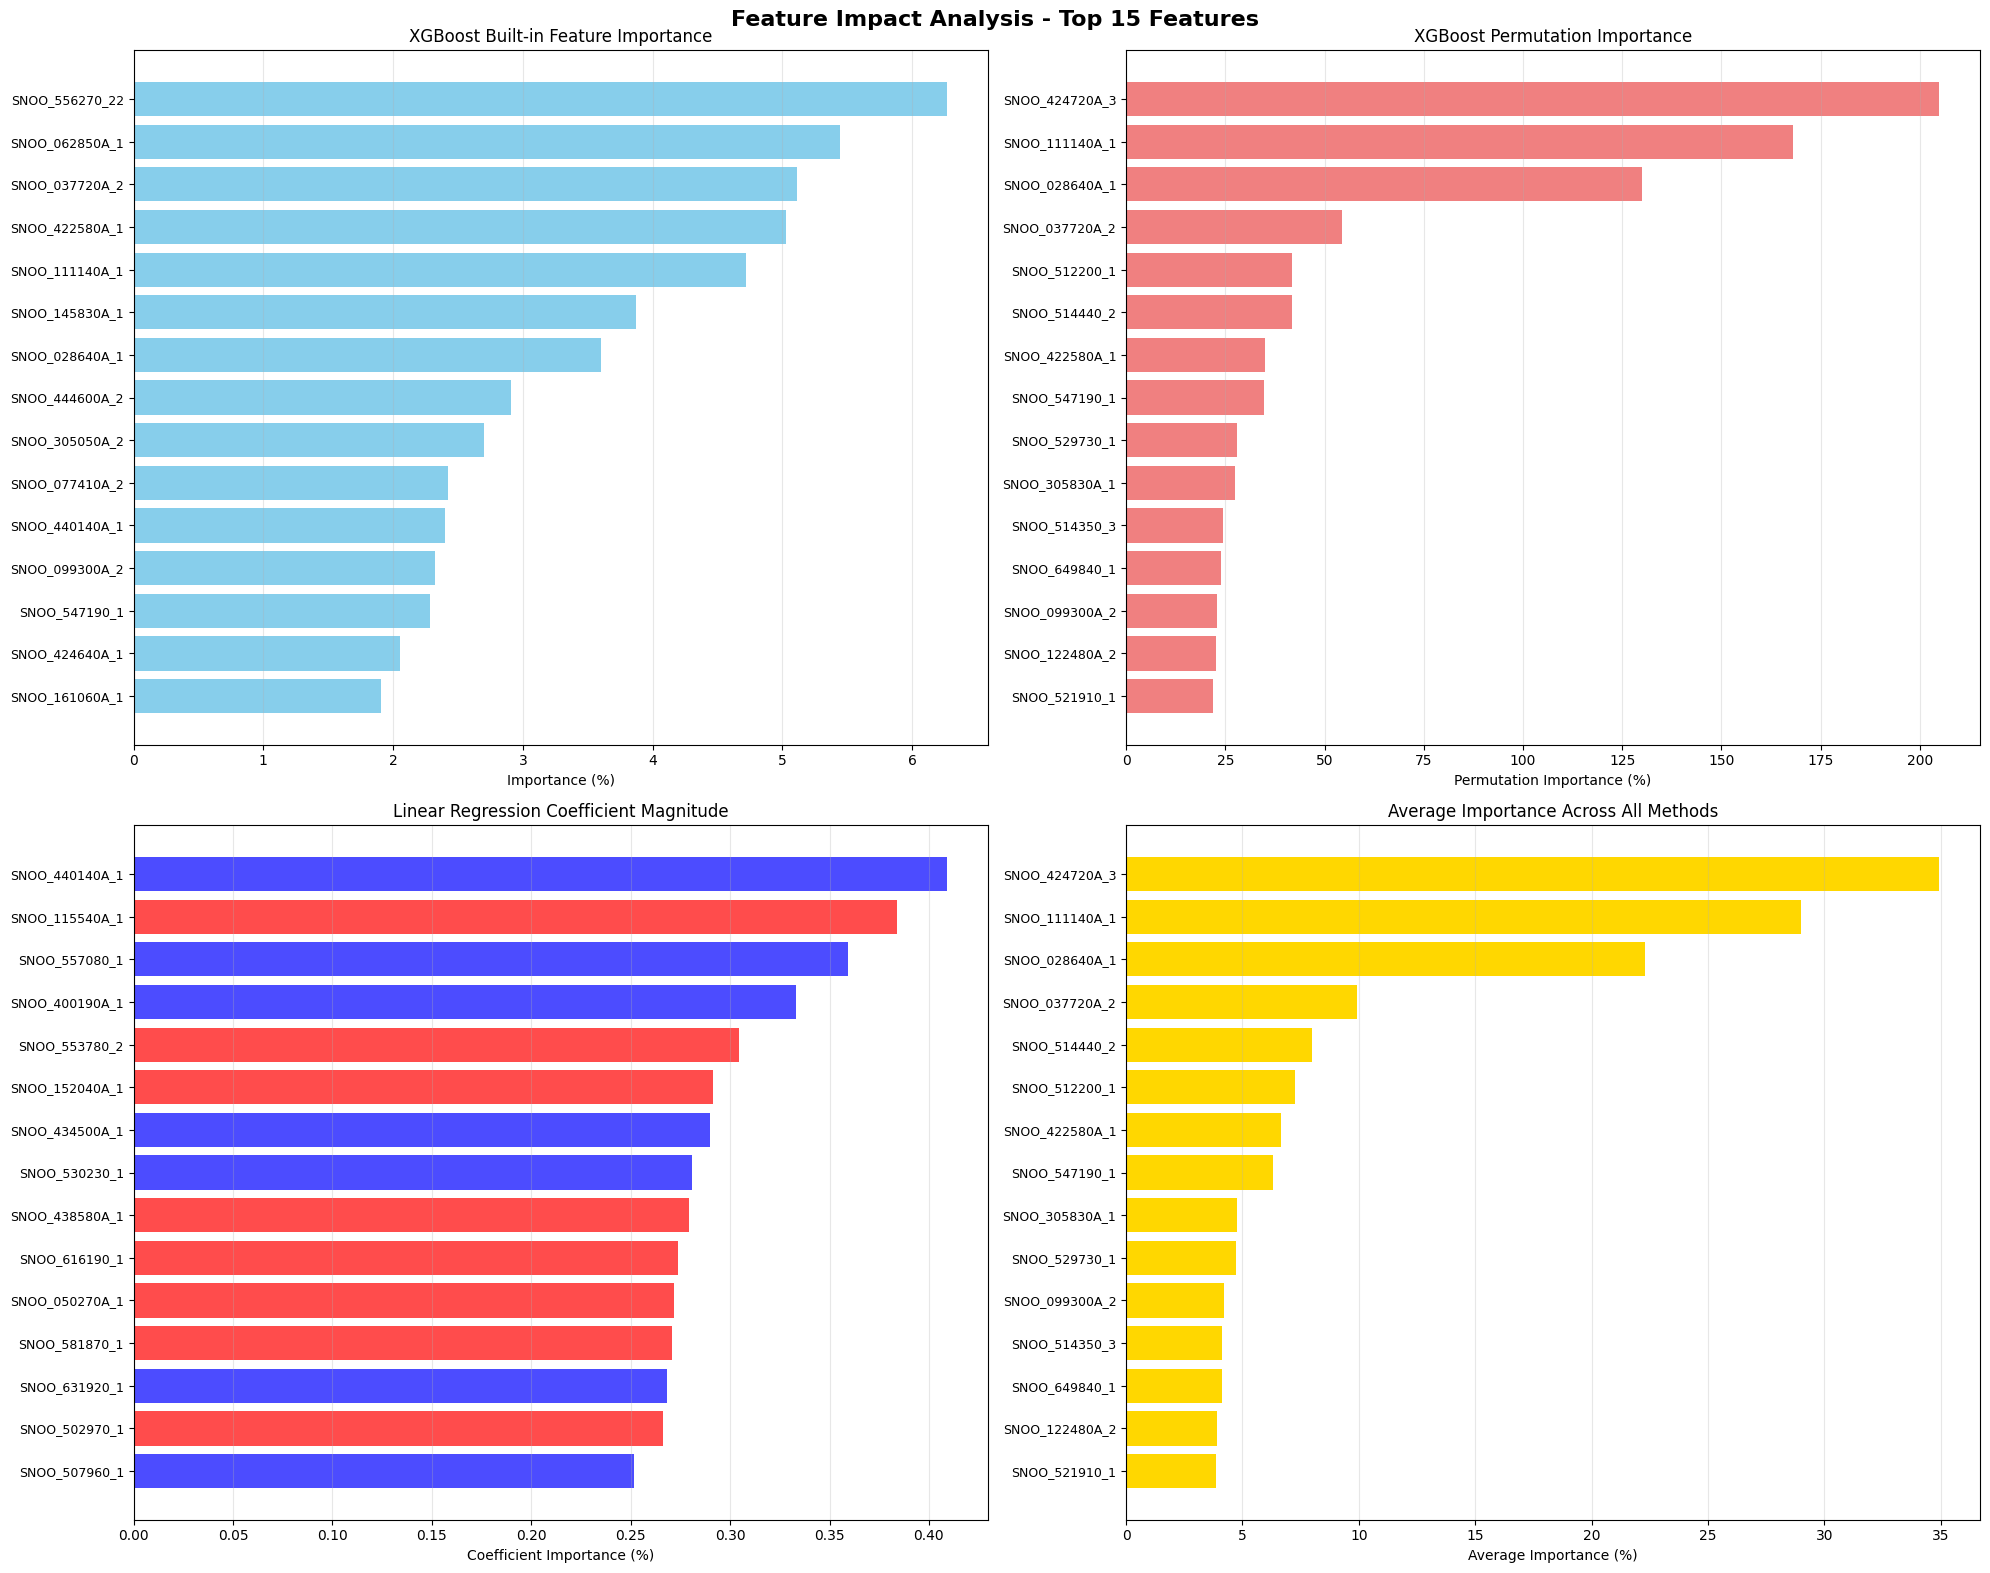

In [25]:
# =============================================================================
# 6. VISUALIZATIONS
# =============================================================================
print("\n" + "="*60)
print("6. CREATING VISUALIZATIONS")
print("="*60)

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Feature Impact Analysis - Top 15 Features', fontsize=16, fontweight='bold')

top_n = 15

# Plot 1: XGBoost Built-in Importance
if 'XGBoost_builtin' in importance_results:
    data = importance_results['XGBoost_builtin'].head(top_n)
    axes[0,0].barh(range(len(data)), data['importance_pct'], color='skyblue')
    axes[0,0].set_yticks(range(len(data)))
    axes[0,0].set_yticklabels(data['feature'], fontsize=9)
    axes[0,0].set_xlabel('Importance (%)')
    axes[0,0].set_title('XGBoost Built-in Feature Importance')
    axes[0,0].invert_yaxis()
    axes[0,0].grid(axis='x', alpha=0.3)

# Plot 2: Permutation Importance
if 'XGBoost_permutation' in importance_results:
    data = importance_results['XGBoost_permutation'].head(top_n)
    axes[0,1].barh(range(len(data)), data['perm_importance_pct'], color='lightcoral')
    axes[0,1].set_yticks(range(len(data)))
    axes[0,1].set_yticklabels(data['feature'], fontsize=9)
    axes[0,1].set_xlabel('Permutation Importance (%)')
    axes[0,1].set_title('XGBoost Permutation Importance')
    axes[0,1].invert_yaxis()
    axes[0,1].grid(axis='x', alpha=0.3)

# Plot 3: Linear Regression Coefficients
if 'linear_regression' in importance_results:
    data = importance_results['linear_regression'].head(top_n)
    colors = ['red' if x < 0 else 'blue' for x in data['coefficient']]
    axes[1,0].barh(range(len(data)), data['coef_importance_pct'], color=colors, alpha=0.7)
    axes[1,0].set_yticks(range(len(data)))
    axes[1,0].set_yticklabels(data['feature'], fontsize=9)
    axes[1,0].set_xlabel('Coefficient Importance (%)')
    axes[1,0].set_title('Linear Regression Coefficient Magnitude')
    axes[1,0].invert_yaxis()
    axes[1,0].grid(axis='x', alpha=0.3)

# Plot 4: Average Importance Summary
data = summary_df.head(top_n)
axes[1,1].barh(range(len(data)), data['avg_importance_pct'], color='gold')
axes[1,1].set_yticks(range(len(data)))
axes[1,1].set_yticklabels(data['feature'], fontsize=9)
axes[1,1].set_xlabel('Average Importance (%)')
axes[1,1].set_title('Average Importance Across All Methods')
axes[1,1].invert_yaxis()
axes[1,1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_impact_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


7. P-VALUE WEIGHT vs MODEL IMPORTANCE CORRELATION
Correlation between P-value weights and XGBoost importance: 0.0174


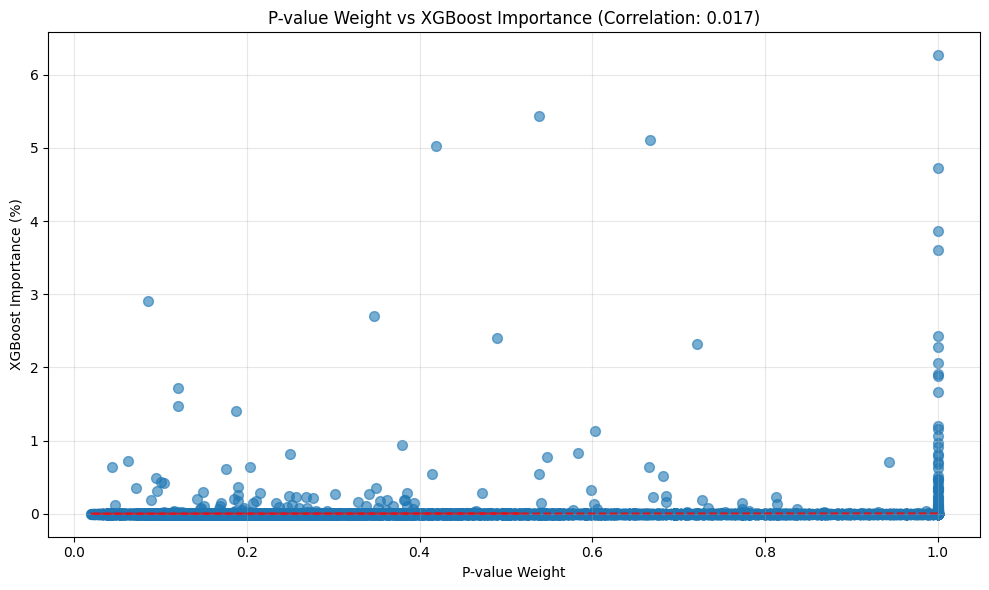

In [26]:
# =============================================================================
# 7. CORRELATION BETWEEN P-VALUE WEIGHTS AND MODEL IMPORTANCE
# =============================================================================
print("\n" + "="*60)
print("7. P-VALUE WEIGHT vs MODEL IMPORTANCE CORRELATION")
print("="*60)

if 'XGBoost_builtin' in importance_results:
    # Calculate correlation
    xgb_data = importance_results['XGBoost_builtin']
    correlation_coef = np.corrcoef(xgb_data['p_value_weight'], xgb_data['importance_pct'])[0,1]

    print(f"Correlation between P-value weights and XGBoost importance: {correlation_coef:.4f}")

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(xgb_data['p_value_weight'], xgb_data['importance_pct'], alpha=0.6, s=50)
    plt.xlabel('P-value Weight')
    plt.ylabel('XGBoost Importance (%)')
    plt.title(f'P-value Weight vs XGBoost Importance (Correlation: {correlation_coef:.3f})')
    plt.grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(xgb_data['p_value_weight'], xgb_data['importance_pct'], 1)
    p = np.poly1d(z)
    plt.plot(xgb_data['p_value_weight'], p(xgb_data['p_value_weight']), "r--", alpha=0.8)

    plt.tight_layout()
    plt.savefig('pvalue_vs_importance_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
# =============================================================================
# 8. FINAL SUMMARY STATISTICS
# =============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY STATISTICS")
print("="*80)

print(f"Total features analyzed: {len(feature_names_filtered)}")
print(f"Features with >1% average importance: {len(summary_df[summary_df['avg_importance_pct'] > 1])}")
print(f"Features with >5% average importance: {len(summary_df[summary_df['avg_importance_pct'] > 5])}")

print(f"\nTop 5 Most Important Features (by average %):")
for i, row in summary_df.head(5).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['avg_importance_pct']:.2f}%")

print(f"\nFiles generated:")
print(f"  - comprehensive_feature_impact_summary.csv")
print(f"  - feature_impact_analysis.png")
print(f"  - pvalue_vs_importance_correlation.png")

print("\n" + "="*80)
print("FEATURE IMPACT ANALYSIS COMPLETE!")
print("="*80)


FINAL SUMMARY STATISTICS
Total features analyzed: 29946
Features with >1% average importance: 38
Features with >5% average importance: 8

Top 5 Most Important Features (by average %):
  5411. SNOO_424720A_3: 34.93%
  24735. SNOO_111140A_1: 28.97%
  25281. SNOO_028640A_1: 22.29%
  29892. SNOO_037720A_2: 9.94%
  23897. SNOO_514440_2: 7.99%

Files generated:
  - comprehensive_feature_impact_summary.csv
  - feature_impact_analysis.png
  - pvalue_vs_importance_correlation.png

FEATURE IMPACT ANALYSIS COMPLETE!
